In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re  # for pattern matching and text manipulation.
import string
import nltk
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
train_data = pd.read_csv("/content/train_data.txt", sep=':::', names=["title", "genre", "description"], engine='python')
test_data = pd.read_csv("/content/test_data.txt", sep=':::', names=["title", "description"], engine='python')

train_data.head()
test_data.head()

,title,description
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


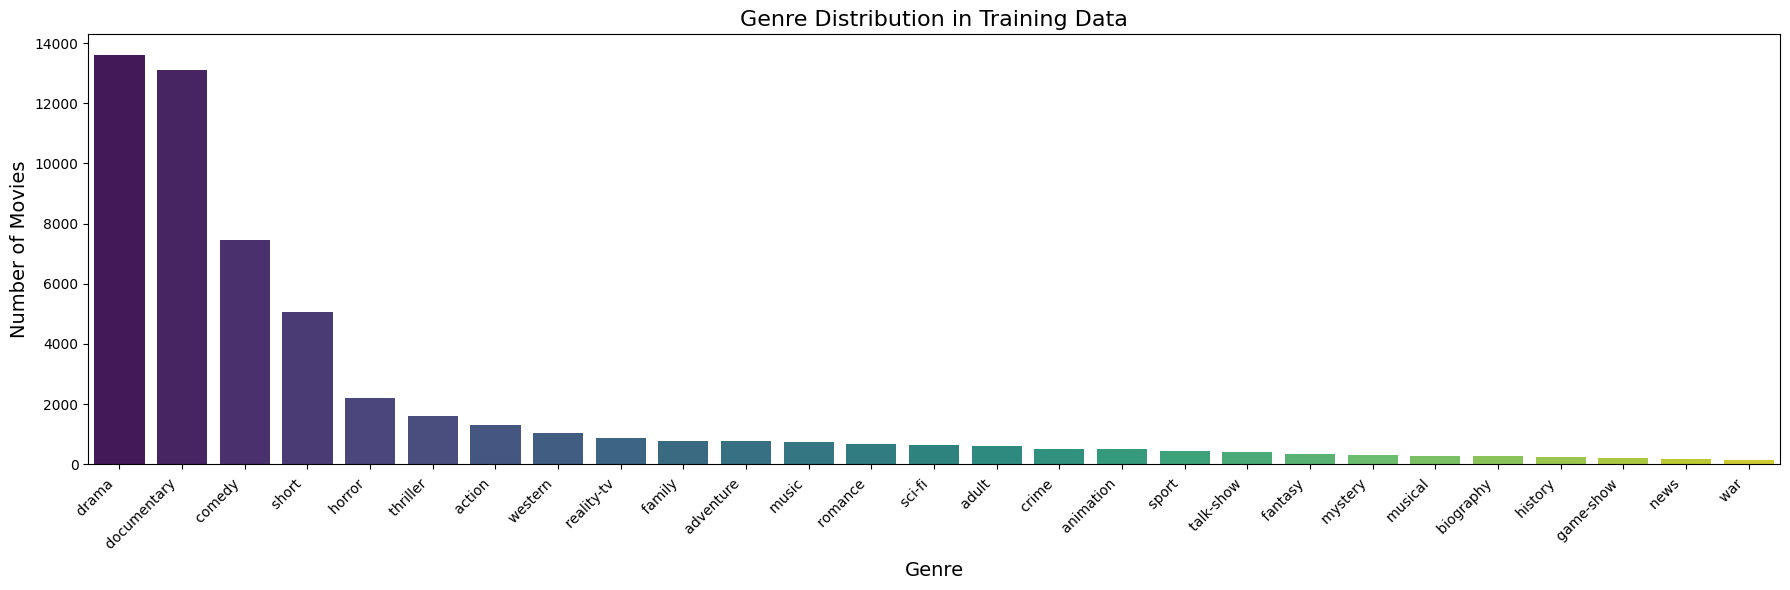

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(18, 6))

# Get value counts of genres
genre_counts = train_data['genre'].value_counts().reset_index()
genre_counts.columns = ['Genre', 'Count']

# Plot the barplot
sns.barplot(data=genre_counts, x='Genre', y='Count', palette='viridis')

# Set labels and formatting
plt.xlabel('Genre', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.title('Genre Distribution in Training Data', fontsize=16)
plt.xticks(rotation=45, ha='right')  # rotate x-axis labels for readability
plt.tight_layout()  # prevent label cut-off

plt.show()


In [ ]:
train_data.describe()

,title,genre,description
count,54214,54214,54214
unique,54214,27,54086
top,Nature's Fury: Storm of the Century (2006),drama,Grammy - music award of the American academy ...
freq,1,13613,12


In [ ]:
train_data.genre.value_counts()

,count
genre,
drama,13613
documentary,13096
comedy,7447
short,5073
horror,2204
thriller,1591
action,1315
western,1032
reality-tv,884


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        54214 non-null  object
 1   genre        54214 non-null  object
 2   description  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
train_data.isnull().sum()

,0
title,0
genre,0
description,0


In [ ]:
# Display shape before removing duplicates
print("Shape before dropping duplicates:", train_data.shape)

# Dropping duplicate rows
train_data = train_data.drop_duplicates()

# Display shape after removing duplicates
print("Shape after dropping duplicates:", train_data.shape)
# Dropping rows with missing (null) values
train_data = train_data.dropna()
print("Shape after dropping null values:", train_data.shape)


Shape before dropping duplicates: (54214, 3)
Shape after dropping duplicates: (54214, 3)
Shape after dropping null values: (54214, 3)


In [ ]:
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download()

In [ ]:
import re, string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# Download stopwords if not already downloaded
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))


def clean_data(text):
    if not text:
        return ''
    text = re.sub(r'@\S+|http\S+|[\w\.-]+@[\w\.-]+|pic.\S+|#|_', ' ', text.lower())
    text = re.sub(r"[^a-z\s']", ' ', text)
    text = re.sub(r'\s+[a-z]\s+', ' ', text + ' ')
    text = re.sub(r'\[[^]]*\]|\n', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    return ' '.join([w for w in tokens if w not in stop_words and len(w) > 2])

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab') # Download the missing resource
from tqdm import tqdm

tqdm.pandas()
train_data['description_cleaned'] = train_data['description'].progress_apply(clean_data)
test_data['description_cleaned'] = test_data['description'].progress_apply(clean_data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|██████████| 54200/54200 [00:33<00:00, 1617.91it/s]


In [ ]:
from nltk.stem import PorterStemmer

# Initialize the stemmer
st = PorterStemmer()

# Apply stemming to each word in the cleaned descriptions
train_data['description_cleaned'] = train_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()])
)

test_data['description_cleaned'] = test_data['description_cleaned'].apply(
    lambda x: ' '.join([st.stem(word) for word in x.split()])
)


In [ ]:
train_data['length']=train_data['description'].apply(len)
train_data['length_cleaned']=train_data['description_cleaned'].apply(len)
train_data.head()

,title,genre,description,description_cleaned,length,length_cleaned
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listen convers doctor parent year old oscar le...,546,339
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...,brother sister past incestu relationship curre...,184,111
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...,bu empti student field trip museum natur histo...,650,343
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...,help unemploy father make end meet edith twin ...,1082,678
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...,film titl refer recov bodi ground zero also st...,625,347


In [ ]:
print("Average Length of Text Before Cleaning: ", train_data['length'].mean())
print("Average Length of Text After Cleaning: ", train_data['length_cleaned'].mean())

Average Length of Text Before Cleaning:  600.4524292618142
Average Length of Text After Cleaning:  359.7177481831261


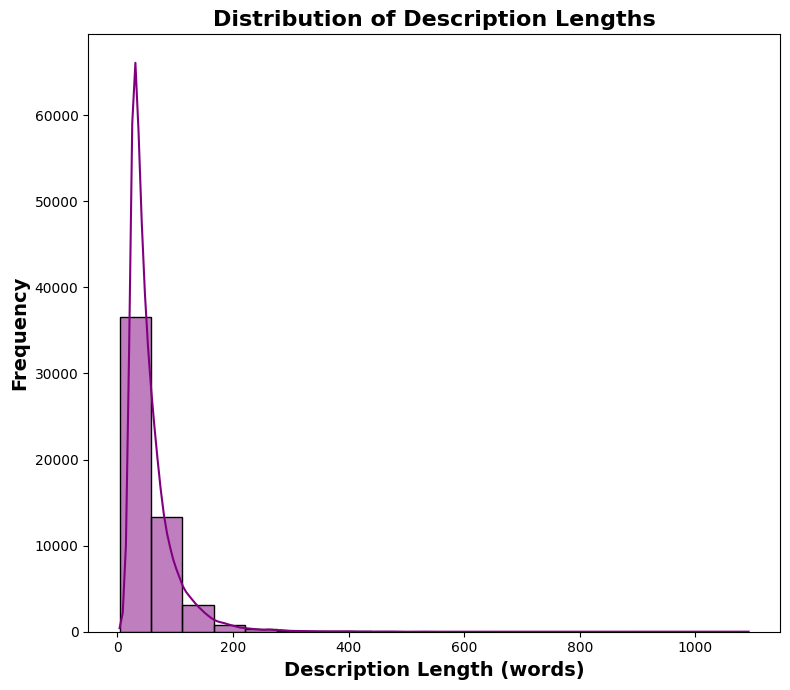

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'length' column exists — if not, create it
train_data['length'] = train_data['description_cleaned'].apply(lambda x: len(x.split()))

# Plot the histogram
plt.figure(figsize=(8, 7))

sns.histplot(data=train_data, x='length', bins=20, kde=True, color='purple')

# Label formatting
plt.xlabel('Description Length (words)', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.title('Distribution of Description Lengths', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


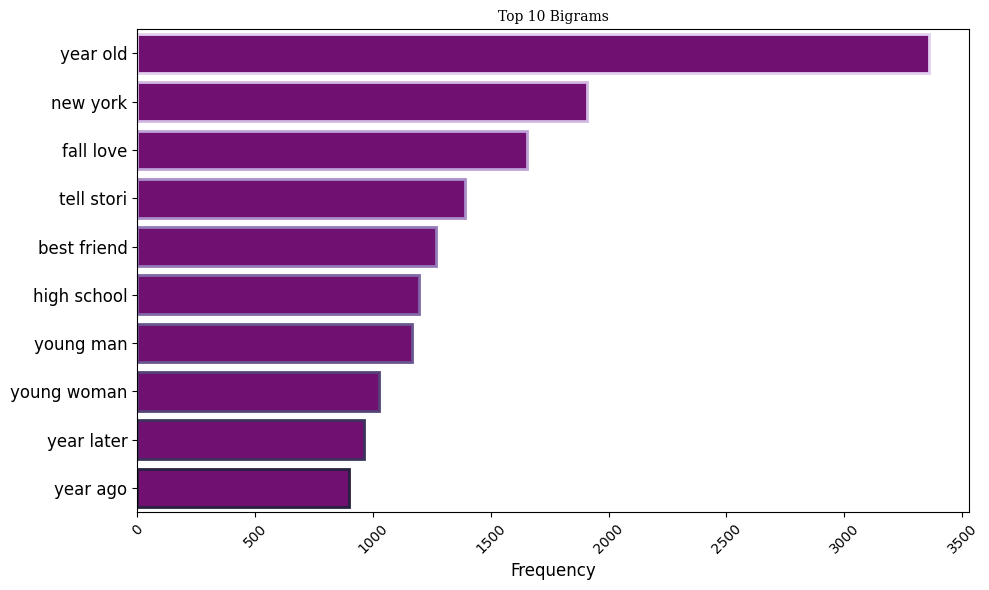

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get top 10 bigrams and convert to DataFrame
common_words = get_top_n_bigram(train_data['description_cleaned'], 10)
common_words_df = pd.DataFrame(common_words, columns=['word', 'freq'])

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='freq',
    y='word',
    data=common_words_df,
    color='purple',  # facecolor='yellow' was not the right argument for sns.barplot
    edgecolor=sns.color_palette("ch:start=3, rot=.1", 10),
    linewidth=2
)

# Styling
plt.title("Top 10 Bigrams", fontsize=16, fontweight='bold', font='serif')
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("")
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [ ]:
le = LabelEncoder()
train_data['genre'] = le.fit_transform(train_data['genre'].values)

# keep only relevent columns
train_df = train_data.loc[:,['description_cleaned', 'genre']]
test_df = test_data.loc[:,['description_cleaned', 'title']]
train_df.head(10)

,description_cleaned,genre
1,listen convers doctor parent year old oscar le...,8
2,brother sister past incestu relationship curre...,24
3,bu empti student field trip museum natur histo...,1
4,help unemploy father make end meet edith twin ...,8
5,film titl refer recov bodi ground zero also st...,8
6,qualiti control consist seri singl take shot f...,7
7,tough econom time max joey run idea discov sen...,5
8,ron petri keanu reev troubl teen whose life ha...,6
9,sudden calamit event caus great loss life dama...,18
10,four high school student embark terrifi journe...,13


In [ ]:
train_set , val_set , train_label , val_label = train_test_split(train_df['description_cleaned'] , train_data['genre'] , test_size=0.2 , shuffle=True , random_state = 42)

print(f'Split data into train and eval sets')
print(f'Trani Set\t: {len(train_set)}\nValidation Set\t: {len(val_set)}')

Split data into train and eval sets
Trani Set	: 43371
Validation Set	: 10843


In [ ]:
# using TF-IDF
vectorize = TfidfVectorizer(stop_words='english', max_features=100000)
train_set_tfidf = vectorize.fit_transform(train_set)
val_set_tfidf = vectorize.transform(val_set)
# using BOW
# vectorize = CV()
# train_set_tfidf = vectorize.fit_transform(train_set)
# val_set_tfidf = vectorize.transform(val_set)

In [ ]:
LR_model = LogisticRegression()
LR_model.fit(train_set_tfidf, train_label)
predict_LR = LR_model.predict(val_set_tfidf)
print(classification_report(val_label, predict_LR))
LR_accuracy = accuracy_score(predict_LR,val_label)
print('Logistic Regression accuracy is: {:.2f}%'.format(LR_accuracy*100))

              precision    recall  f1-score   support

           0       0.55      0.28      0.37       263
           1       0.84      0.28      0.42       112
           2       0.42      0.12      0.19       139
           3       0.38      0.03      0.05       104
           4       0.00      0.00      0.00        61
           5       0.52      0.59      0.55      1443
           6       0.22      0.02      0.03       107
           7       0.66      0.84      0.74      2659
           8       0.53      0.79      0.64      2697
           9       0.42      0.09      0.15       150
          10       0.00      0.00      0.00        74
          11       0.94      0.38      0.54        40
          12       0.00      0.00      0.00        45
          13       0.66      0.58      0.62       431
          14       0.69      0.47      0.56       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        56
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no pre

In [ ]:
# Train a Naive Bayes classifier
NB_model = MultinomialNB()
NB_model.fit(train_set_tfidf, train_label)
y_pred_naive = NB_model.predict(val_set_tfidf)
print(classification_report(val_label, y_pred_naive))
naive_accuracy = accuracy_score(y_pred_naive,val_label)
print('Naive Bayes model accuracy is: {:.2f}%'.format(naive_accuracy*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.66      0.05      0.09      1443
           6       0.00      0.00      0.00       107
           7       0.51      0.89      0.65      2659
           8       0.38      0.87      0.53      2697
           9       0.00      0.00      0.00       150
          10       0.00      0.00      0.00        74
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00       431
          14       0.00      0.00      0.00       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        56
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
DT = DecisionTreeClassifier(max_depth=(1), random_state=0)
DT.fit(train_set_tfidf, train_label)
predict_ID3 = DT.predict(val_set_tfidf)
print(classification_report(val_label, predict_ID3))
ID3_accuracy = accuracy_score(predict_ID3,val_label)
print('ID3 model accuracy is: {:.2f}%'.format(ID3_accuracy*100))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       263
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00       139
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        61
           5       0.00      0.00      0.00      1443
           6       0.00      0.00      0.00       107
           7       0.82      0.31      0.45      2659
           8       0.27      0.99      0.43      2697
           9       0.00      0.00      0.00       150
          10       0.00      0.00      0.00        74
          11       0.00      0.00      0.00        40
          12       0.00      0.00      0.00        45
          13       0.00      0.00      0.00       431
          14       0.00      0.00      0.00       144
          15       0.00      0.00      0.00        50
          16       0.00      0.00      0.00        56
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Train a SVC classifier
from sklearn.svm import LinearSVC
svm_model = LinearSVC()
svm_model.fit(train_set_tfidf, train_label)
predict = svm_model.predict(val_set_tfidf)

print(classification_report(val_label, predict))
svm_accuracy = accuracy_score(predict,val_label)
print('SVC model accuracy is: {:.2f}%'.format(svm_accuracy*100))

              precision    recall  f1-score   support

           0       0.46      0.34      0.39       263
           1       0.67      0.44      0.53       112
           2       0.39      0.21      0.27       139
           3       0.35      0.13      0.19       104
           4       0.00      0.00      0.00        61
           5       0.53      0.59      0.56      1443
           6       0.23      0.07      0.10       107
           7       0.68      0.80      0.73      2659
           8       0.55      0.70      0.62      2697
           9       0.37      0.13      0.20       150
          10       0.36      0.05      0.09        74
          11       0.83      0.62      0.71        40
          12       0.25      0.02      0.04        45
          13       0.60      0.64      0.62       431
          14       0.56      0.55      0.56       144
          15       0.27      0.06      0.10        50
          16       0.20      0.02      0.03        56
          17       0.25    

In [ ]:
columns=['LogisticRegression', 'MultinomialNB', 'Decision_Tree','SVC']
accuracy= [LR_accuracy, naive_accuracy, ID3_accuracy, svm_accuracy]

FinalResult=pd.DataFrame({'Algorithm':columns, 'Accuracy':accuracy})

FinalResult

,Algorithm,Accuracy
0,LogisticRegression,0.579913
1,MultinomialNB,0.440745
2,Decision_Tree,0.322973
3,SVC,0.571613


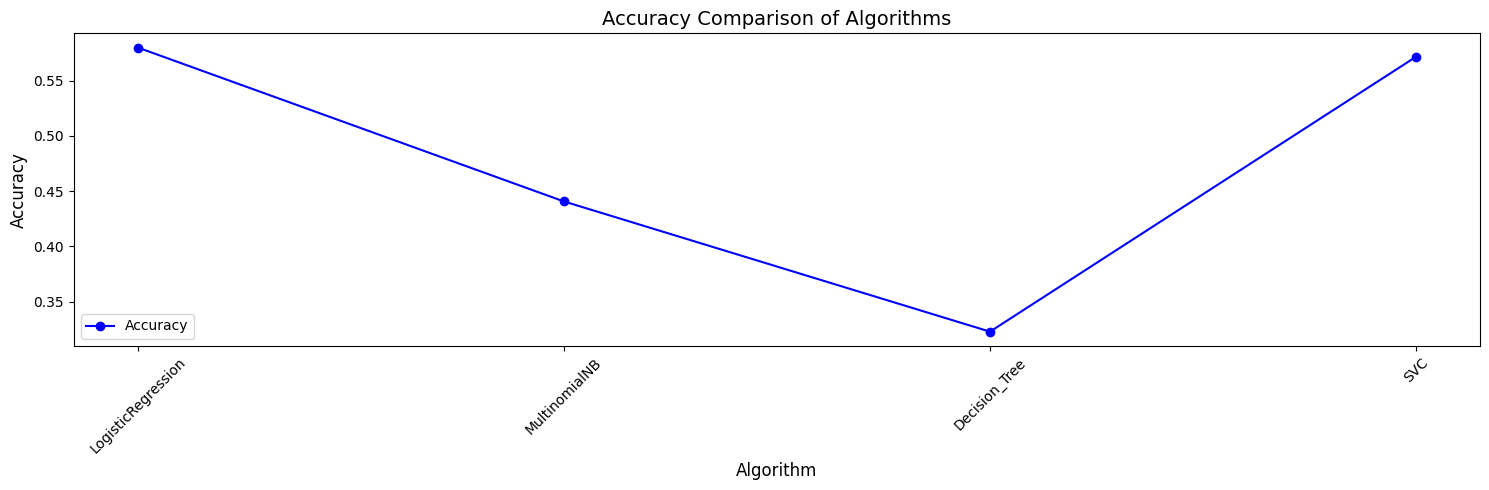

In [ ]:
import matplotlib.pyplot as plt

# Make sure FinalResult is defined and has the right columns
# For example:
# FinalResult = pd.DataFrame({
#     'Algorithm': ['SVM', 'Naive Bayes', 'Random Forest'],
#     'accuracy': [0.85, 0.80, 0.90]
# })

fig, ax = plt.subplots(figsize=(15, 5))

# Plot accuracy line with blue color and circular markers
ax.plot(FinalResult['Algorithm'], FinalResult['Accuracy'],
        marker='o', color='blue', label='Accuracy')

# Labels and formatting
ax.set_xlabel("Algorithm", fontsize=12)
ax.set_ylabel("Accuracy", fontsize=12)
ax.set_title("Accuracy Comparison of Algorithms", fontsize=14)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()